# Introduction

## Importations

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gc
import time
from contextlib import contextmanager

from itertools import product

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import shap

import warnings
warnings.filterwarnings("ignore")

In [34]:
@contextmanager
def timer(title, p = 3) :
    start_time = time.time()
    yield
    duration = round(time.time() - start_time, p)
    print(title, ":", duration, "seconde(s)")

In [35]:
with timer("Temps de chargement des données") :
    app_train = pd.read_csv("csv/preprocessed/app_train.csv")
    app_test = pd.read_csv("csv/preprocessed/app_test.csv")

print("\nDimensions du jeu d'entraînement :", app_train.shape)
print("Dimensions du jeu de test :", app_test.shape)

Temps de chargement des données : 16.815 seconde(s)

Dimensions du jeu d'entraînement : (246005, 772)
Dimensions du jeu de test : (61502, 772)


## Choix de la métrique

In [36]:
def rge_score(labels, binary_preds, credit_amounts, interest_ratio = 0.1) :
    
    expected_gain = 0
    effective_gain = 0
    
    for label, pred, credit_amount in zip(labels, binary_preds, credit_amounts) :
        if label == 0 :
            expected_gain += interest_ratio * credit_amount
            if pred == 0 :
                effective_gain += interest_ratio * credit_amount
        if label == 1 and pred == 0 :
            effective_gain -= credit_amount
            
    return effective_gain / expected_gain

In [37]:
X_train = app_train.drop(columns = ["TARGET"])
X_test = app_test.drop(columns = ["TARGET"])
y_train = app_train["TARGET"]
y_test = app_test["TARGET"]

for strategy in ["uniform", "stratified", "most_frequent"] :
    dummy = DummyClassifier(strategy = strategy)
    dummy.fit(X_train, y_train)
    preds = dummy.predict(X_test)
    rge = rge_score(y_test, preds, X_test["AMT_CREDIT"])
    print(f"Score RGE du {strategy} dummy classifier sur le jeu de test : {round(rge, 5)}")
    
del X_train, X_test, y_train, y_test, dummy, preds

Score RGE du uniform dummy classifier sur le jeu de test : 0.09546
Score RGE du stratified dummy classifier sur le jeu de test : 0.17277
Score RGE du most_frequent dummy classifier sur le jeu de test : 0.18866


## Sélection des features

In [38]:
"""
max_corr = 0.9
max_iter = 100

with timer("Temps de traitement") :
    selected_features = select_correlated_features(app_train, max_corr, max_iter)
"""

with open("selected_features.txt", "r") as file :
    lines = file.readlines()

selected_features = [line.strip() for line in lines]

In [39]:
correlations_with_target = app_train[selected_features].corrwith(app_train["TARGET"])
correlations_with_target_sorted = correlations_with_target.abs().sort_values(ascending = False)

print("Les 10 features les plus corrélées à la cible (en valeur absolue) :")
display(correlations_with_target_sorted.head(10))

del correlations_with_target, correlations_with_target_sorted

Les 10 features les plus corrélées à la cible (en valeur absolue) :


EXT_SOURCE_3                          0.178294
EXT_SOURCE_2                          0.159707
EXT_SOURCE_1                          0.156417
CARD_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.110066
CARD_CNT_DRAWINGS_CURRENT_MAX         0.101012
BUREAU_DAYS_CREDIT_MEAN               0.088423
CARD_AMT_BALANCE_MEAN                 0.086212
CARD_CNT_DRAWINGS_CURRENT_MEAN        0.083586
DAYS_BIRTH                            0.079716
BUREAU_MONTHS_BALANCE_SIZE_MEAN       0.079529
dtype: float64

## Détection du datadrift

# Construction d'un modèle

## Prétraitement des données

In [40]:
def preprocess_data(df_train, df_test, selected_features) :
    
    # Extraction des features avec copie
    data = {
        "X_train" : df_train[selected_features].copy(),
        "X_test" : df_test[selected_features].copy(),
        "y_train" : df_train["TARGET"].copy(),
        "y_test" : df_test["TARGET"].copy(),
        "amt_credit_train" : df_train["AMT_CREDIT"].copy(),
        "amt_credit_test" : df_test["AMT_CREDIT"].copy()
    }
    
    # Abandon des éventuelles colonnes n'ayant qu'une seule valeur
    columns_to_drop = data["X_train"].columns[data["X_train"].nunique() == 1]
    X_train_cleaned = data["X_train"].drop(columns = columns_to_drop)
    X_test_cleaned = data["X_test"].drop(columns = columns_to_drop)
    
    # Imputation des valeurs manquantes par la médiane
    imputer = SimpleImputer(strategy = "median")
    X_train_imputed = imputer.fit_transform(X_train_cleaned)
    X_test_imputed = imputer.transform(X_test_cleaned)
    
    # Normalisation des valeurs
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Réattribution des noms des colonnes
    data["X_train"] = pd.DataFrame(X_train_scaled, columns = X_train_cleaned.columns)
    data["X_test"] = pd.DataFrame(X_test_scaled, columns = X_test_cleaned.columns)
    
    return data

In [41]:
with timer("Temps de prétraitement") :
    processed_data = preprocess_data(app_train, app_test, selected_features)

for name, df in processed_data.items() :
    print(name, ":", df.shape)

Temps de prétraitement : 3.756 seconde(s)
X_train : (246005, 100)
X_test : (61502, 100)
y_train : (246005,)
y_test : (61502,)
amt_credit_train : (246005,)
amt_credit_test : (61502,)


## Entraînement et prédictions

In [42]:
logreg = LogisticRegression()
logreg.fit(processed_data["X_train"], processed_data["y_train"])

preds_train = logreg.predict(processed_data["X_train"])
preds_test = logreg.predict(processed_data["X_test"])

rge_train = rge_score(processed_data["y_train"], preds_train, processed_data["amt_credit_train"])
rge_test = rge_score(processed_data["y_test"], preds_test, processed_data["amt_credit_test"])

print("--- Baseline (LogisticRegression) ---")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

del preds_train, preds_test

--- Baseline (LogisticRegression) ---
Score RGE sur le jeu d'entraînement : 0.19744
Score RGE sur le jeu de test : 0.19999


In [43]:
proba_preds_train = logreg.predict_proba(processed_data["X_train"])[:, 1]
proba_preds_test = logreg.predict_proba(processed_data["X_test"])[:, 1]

binary_preds_train = (proba_preds_train >= 0.5).astype(int)
binary_preds_test = (proba_preds_test >= 0.5).astype(int)

rge_train = rge_score(processed_data["y_train"], binary_preds_train, processed_data["amt_credit_train"])
rge_test = rge_score(processed_data["y_test"], binary_preds_test, processed_data["amt_credit_test"])

print("--- LogisticRegression ---")
print("Seuil d'acceptation : 0.5")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

--- LogisticRegression ---
Seuil d'acceptation : 0.5
Score RGE sur le jeu d'entraînement : 0.19744
Score RGE sur le jeu de test : 0.19999


In [44]:
binary_preds_train = (proba_preds_train >= 0.2).astype(int)
binary_preds_test = (proba_preds_test >= 0.2).astype(int)

rge_train = rge_score(processed_data["y_train"], binary_preds_train, processed_data["amt_credit_train"])
rge_test = rge_score(processed_data["y_test"], binary_preds_test, processed_data["amt_credit_test"])

print("--- LogisticRegression ---")
print("Seuil d'acceptation : 0.2")
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

--- LogisticRegression ---
Seuil d'acceptation : 0.2
Score RGE sur le jeu d'entraînement : 0.3303
Score RGE sur le jeu de test : 0.33372


## Optimisation du seuil d'acceptation

In [45]:
def get_rge_by_acceptance(labels, proba_preds, credit_amounts) :
    
    acceptance_values = np.linspace(0, 1, 100)
    rge_values = []
    
    for acceptance in acceptance_values :
        binary_preds = (proba_preds >= acceptance).astype(int)
        rge = rge_score(labels, binary_preds, credit_amounts)
        rge_values.append(rge)
    
    return acceptance_values, rge_values

In [46]:
def plot_rge_by_acceptance(acceptance_values, rge_values) :
    
    plt.figure(figsize = (5, 3))
    plt.plot(acceptance_values, rge_values)
    
    plt.xlabel("Seuil d'acceptation")
    plt.ylabel(f"Score RGE")
    plt.title("Score RGE par seuil d'acceptation")
    plt.grid(True)
    
    plt.show()

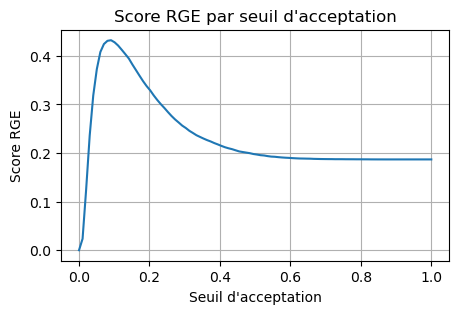

In [47]:
acceptance_values, rge_values = get_rge_by_acceptance(
    labels = processed_data["y_train"],
    proba_preds = proba_preds_train,
    credit_amounts = processed_data["amt_credit_train"]
)

plot_rge_by_acceptance(acceptance_values, rge_values)

In [48]:
best_index = np.argmax(rge_values)
best_acceptance = acceptance_values[best_index]
binary_preds_test = (proba_preds_test >= best_acceptance).astype(int)

rge_train = rge_values[best_index]
rge_test = rge_score(processed_data["y_test"], binary_preds_test, processed_data["amt_credit_test"])

print("Seuil d'acceptation optimal :", round(best_acceptance, 2))
print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")

del proba_preds_train, proba_preds_test, binary_preds_train, binary_preds_test, acceptance_values, rge_values

Seuil d'acceptation optimal : 0.09
Score RGE sur le jeu d'entraînement : 0.43209
Score RGE sur le jeu de test : 0.44624


# Méthodes d'équilibrage

## Equilibrage des données

In [49]:
def balance_data(processed_data, strategy = None) :
    
    # Copie des données fournies en argument
    data = {name : df.copy() for name, df in processed_data.items()}
    
    # Sélection du sampler suivant la stratégie d'équilibrage
    if strategy == "over" :
        sampler = RandomOverSampler(random_state = 42)        
    elif strategy == "under" :
        sampler = RandomUnderSampler(random_state = 42)
    elif strategy == "smote" :
        sampler = SMOTE(random_state = 42)
    else :
        # Simple recopie dans le cas sans équilibrage
        data["X_train_balanced"] = data["X_train"]
        data["y_train_balanced"] = data["y_train"]
        return data
    
    # Ajout temporaire des montants des crédits à X_train
    data["X_train"]["temp"] = data["amt_credit_train"].copy()
    
    # Application du sampler
    data["X_train_balanced"], data["y_train_balanced"] = sampler.fit_resample(data["X_train"], data["y_train"])
    
    # Récupération du montants des crédits
    data["amt_credit_train"] = data["X_train_balanced"].pop("temp")
    data["X_train"].drop(columns = ["temp"], inplace = True)
        
    return data

In [50]:
gc.collect()

print("--- Standard ---")
data_standard = balance_data(processed_data)
for name, df in data_standard.items() :
    print(name, ":", df.shape)

print("\n--- Oversampling ---")
data_over = balance_data(processed_data, strategy = "over")
for name, df in data_over.items() :
    print(name, ":", df.shape)
    
print("\n--- Undersampling ---")
data_under = balance_data(processed_data, strategy = "under")
for name, df in data_under.items() :
    print(name, ":", df.shape)

print("\n--- SMOTE ---")
data_smote = balance_data(processed_data, strategy = "smote")
for name, df in data_smote.items() :
    print(name, ":", df.shape)

#del processed_data

--- Standard ---
X_train : (246005, 100)
X_test : (61502, 100)
y_train : (246005,)
y_test : (61502,)
amt_credit_train : (246005,)
amt_credit_test : (61502,)
X_train_balanced : (246005, 100)
y_train_balanced : (246005,)

--- Oversampling ---
X_train : (246005, 100)
X_test : (61502, 100)
y_train : (246005,)
y_test : (61502,)
amt_credit_train : (452290,)
amt_credit_test : (61502,)
X_train_balanced : (452290, 100)
y_train_balanced : (452290,)

--- Undersampling ---
X_train : (246005, 100)
X_test : (61502, 100)
y_train : (246005,)
y_test : (61502,)
amt_credit_train : (39720,)
amt_credit_test : (61502,)
X_train_balanced : (39720, 100)
y_train_balanced : (39720,)

--- SMOTE ---
X_train : (246005, 100)
X_test : (61502, 100)
y_train : (246005,)
y_test : (61502,)
amt_credit_train : (452290,)
amt_credit_test : (61502,)
X_train_balanced : (452290, 100)
y_train_balanced : (452290,)


## Tests comparatifs

In [51]:
def apply_classifier(data, classifier) :
    
    classifier.fit(data["X_train_balanced"], data["y_train_balanced"])

    preds = {
        "proba_train" : classifier.predict_proba(data["X_train"])[:, 1],
        "proba_test" : classifier.predict_proba(data["X_test"])[:, 1]
    }

    acceptance_values, rge_values = get_rge_by_acceptance(data["y_train"], preds["proba_train"], data["amt_credit_train"])
    
    preds["acceptance_curve"] = (acceptance_values, rge_values)
    preds["acceptance"] = acceptance_values[np.argmax(rge_values)]
    
    preds["binary_train"] = (preds["proba_train"] >= preds["acceptance"]).astype(int)
    preds["binary_test"] = (preds["proba_test"] >= preds["acceptance"]).astype(int)

    return preds

In [52]:
def evaluate_preds(data, preds, display_results = True, display_curve = False) :
    
    rge_train = rge_score(data["y_train"], preds["binary_train"], data["amt_credit_train"])
    rge_test = rge_score(data["y_test"], preds["binary_test"], data["amt_credit_test"])
    
    if display_results :
        print("Seuil d'acceptation :", round(preds["acceptance"], 2))
        print(f"Score RGE sur le jeu d'entraînement : {round(rge_train, 5)}")
        print(f"Score RGE sur le jeu de test : {round(rge_test, 5)}")
    
    if display_curve :
        acceptance_values, rge_values = preds["acceptance_curve"]
        plot_rge_by_acceptance(acceptance_values, rge_values)
        
    return rge_train, rge_test

--- LogisticRegression (standard) ---
Seuil d'acceptation : 0.09
Score RGE sur le jeu d'entraînement : 0.43209
Score RGE sur le jeu de test : 0.44624


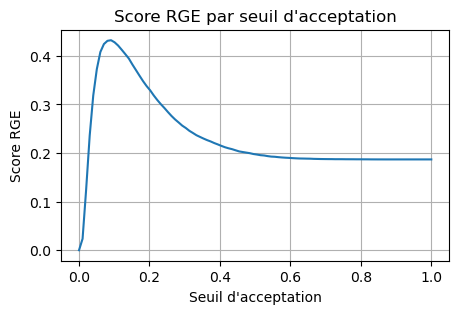

In [53]:
preds = apply_classifier(data_standard, logreg)

print("--- LogisticRegression (standard) ---")
rge_train, rge_test = evaluate_preds(data_standard, preds, display_curve = True)

--- LogisticRegression (oversampling) ---
Seuil d'acceptation : 0.52
Score RGE sur le jeu d'entraînement : 0.43305
Score RGE sur le jeu de test : 0.44286


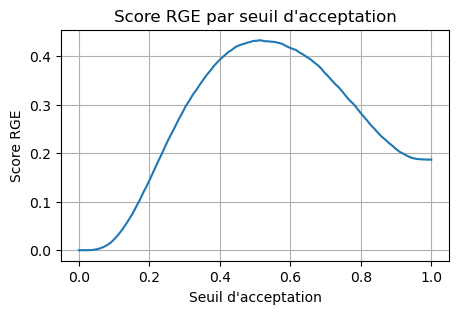

In [54]:
preds = apply_classifier(data_over, logreg)

print("--- LogisticRegression (oversampling) ---")
rge_train, rge_test = evaluate_preds(data_over, preds, display_curve = True)

--- LogisticRegression (undersampling) ---
Seuil d'acceptation : 0.54
Score RGE sur le jeu d'entraînement : 0.40315
Score RGE sur le jeu de test : 0.44527


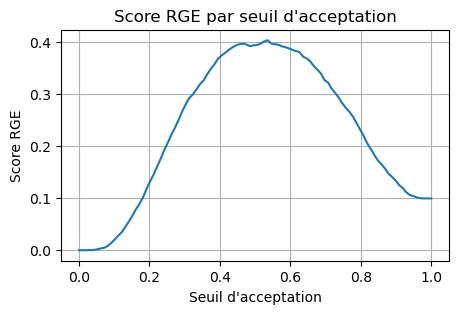

In [55]:
preds = apply_classifier(data_under, logreg)

print("--- LogisticRegression (undersampling) ---")
rge_train, rge_test = evaluate_preds(data_under, preds, display_curve = True)

--- LogisticRegression (SMOTE) ---
Seuil d'acceptation : 0.52
Score RGE sur le jeu d'entraînement : 0.42762
Score RGE sur le jeu de test : 0.43324


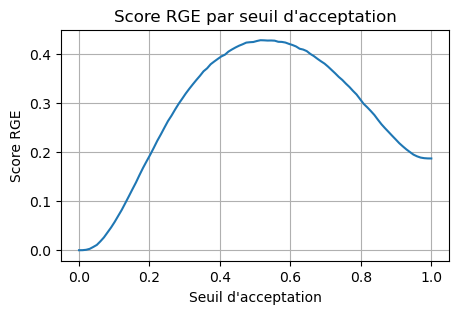

In [56]:
preds = apply_classifier(data_smote, logreg)

print("--- LogisticRegression (SMOTE) ---")
rge_train, rge_test = evaluate_preds(data_smote, preds, display_curve = True)

# Gradient Boosting

In [57]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "num_leaves" : 30,
    "learning_rate" : 0.05,
    "feature_fraction" : 0.9,
    "bagging_fraction" : 0.8, 
    "bagging_freq" : 5,
    "n_estimators" : 100,
    "verbose" : -1,
    "random_state" : 42
}

lgbm_clf = LGBMClassifier(**lgbm_params)

--- LogisticRegression (standard) ---
Seuil d'acceptation : 0.09
Score RGE sur le jeu d'entraînement : 0.47914
Score RGE sur le jeu de test : 0.45759


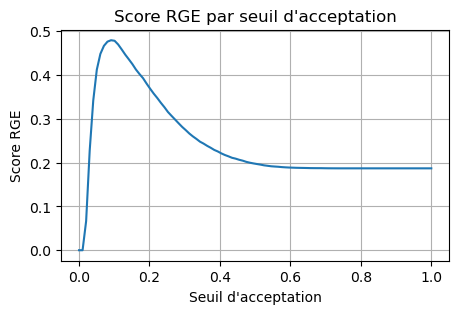

In [58]:
preds = apply_classifier(data_standard, lgbm_clf)

print("--- LogisticRegression (standard) ---")
rge_train, rge_test = evaluate_preds(data_standard, preds, display_curve = True)

--- LogisticRegression (oversampling) ---
Seuil d'acceptation : 0.51
Score RGE sur le jeu d'entraînement : 0.47586
Score RGE sur le jeu de test : 0.46749


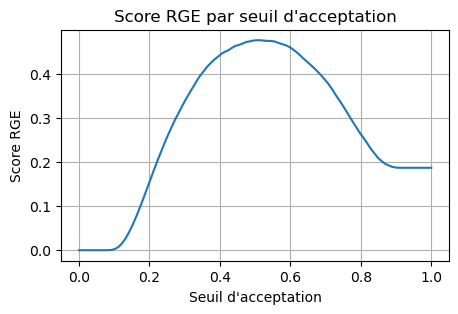

In [59]:
preds = apply_classifier(data_over, lgbm_clf)

print("--- LogisticRegression (oversampling) ---")
rge_train, rge_test = evaluate_preds(data_over, preds, display_curve = True)

--- LogisticRegression (undersampling) ---
Seuil d'acceptation : 0.52
Score RGE sur le jeu d'entraînement : 0.45286
Score RGE sur le jeu de test : 0.46071


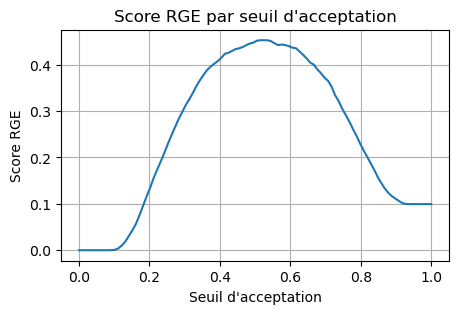

In [60]:
preds = apply_classifier(data_under, lgbm_clf)

print("--- LogisticRegression (undersampling) ---")
rge_train, rge_test = evaluate_preds(data_under, preds, display_curve = True)

--- LogisticRegression (SMOTE) ---
Seuil d'acceptation : 0.16
Score RGE sur le jeu d'entraînement : 0.38506
Score RGE sur le jeu de test : 0.37761


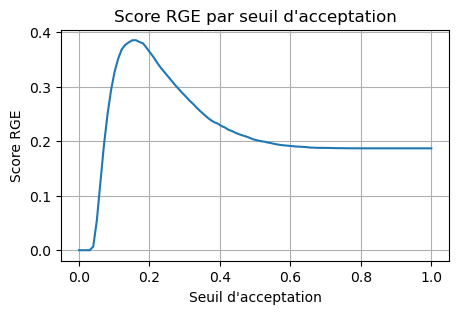

In [61]:
preds = apply_classifier(data_smote, lgbm_clf)

print("--- LogisticRegression (SMOTE) ---")
rge_train, rge_test = evaluate_preds(data_smote, preds, display_curve = True)

# Recherche d'hyperparamètres

## Validation croisée

In [30]:
def preprocess_folds(X, y, preprocessor, n_folds = 5, stratify = True, verbose = 1) :
    
    if stratify :
        folds = StratifiedKFold(n_splits = n_folds, shuffle = True, random_state = 42)
    else :
        folds = KFold(n_splits = n_folds, shuffle = True, random_state = 42)
    
    folds_data = []
    
    for fold, (train_index, valid_index) in enumerate(folds.split(X, y)) :
        
        if verbose > 0 :
            print(f"Prétraitement du fold {fold + 1}/{n_folds}.")
            
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        data = preprocessor(X_train, X_valid, y_train, y_valid)
        folds_data.append(data)
    
    if verbose > 0 :
        print("Prétraitement terminé.")
    
    return folds_data

In [31]:
def standard_preprocessor(X_train, X_valid, y_train, y_valid) :
    df_train = X_train.assign(**{"TARGET" : y_train})
    df_test = X_valid.assign(**{"TARGET" : y_valid})
    return preprocess_data(df_train, df_test, selected_features = X_train.columns)

def oversampling_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "over")

def undersampling_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "under")

def smote_preprocessor(X_train, X_valid, y_train, y_valid) :
    return preprocess_with_balancing(X_train, X_valid, y_train, y_valid, strategy = "smote")

In [32]:
X = app_train.drop(columns = ["SK_ID_CURR", "TARGET"])
y = app_train["TARGET"].copy()

print("--- Prétraitement des folds (standard) ---")
folds_data_standard = preprocess_folds(X, y, standard_preprocessor)

print("--- Prétraitement des folds (oversampling) ---")
folds_data_over = preprocess_folds(X, y, oversampling_preprocessor)

print("--- Prétraitement des folds (undersampling) ---")
folds_data_under = preprocess_folds(X, y, undersampling_preprocessor)

print("--- Prétraitement des folds (SMOTE) ---")
folds_data_smote = preprocess_folds(X, y, smote_preprocessor)

del X, y

--- Prétraitement des folds (standard) ---
Prétraitement du fold 1/5.
Prétraitement du fold 2/5.
Prétraitement du fold 3/5.
Prétraitement du fold 4/5.
Prétraitement du fold 5/5.
Prétraitement terminé.
--- Prétraitement des folds (oversampling) ---
Prétraitement du fold 1/5.


NameError: name 'preprocess_with_balancing' is not defined

In [ ]:
def cross_validation(folds_data, classifier, verbose = 2) :
    
    scores = []
    
    for fold, data in enumerate(folds_data) :
        
        preds = apply_classifier(data, classifier)
        rge_train, rge_valid = evaluate_preds(data, preds, display_results = False)
        scores.append(rge_valid)

        if verbose > 1 :
            print("Score RGE sur le fold ", fold + 1, "/", len(folds_data), " : ", round(rge_valid, 5), sep = "")

    scores.insert(0, np.mean(scores))
    
    if verbose > 0 :
        print("Score RGE moyen : ", round(scores[0], 5))

    return scores

In [ ]:
print("--- Logistic Regression (standard preprocessing) ---")
cv_scores = cross_validation(folds_data_standard, LogisticRegression())

## Grille de recherche

In [ ]:
def generate_param_combinations(param_grid) :
    
    keys = param_grid.keys()
    values = param_grid.values()
    
    return [dict(zip(keys, value)) for value in product(*values)]

In [ ]:
def grid_search(folds_data, classifier_builder, param_grid, verbose = 1) :

    param_combinations = generate_param_combinations(param_grid)
    
    if verbose > 0 :
        print("Lancement de la grille de recherche sur", len(param_combinations), "jeux de paramètres.")

    best_score = float("-inf")
    best_params = None

    for step, params in enumerate(param_combinations) :
        
        if verbose > 0 :
            print("\nEtape ", step + 1, "/", len(param_combinations), sep = "")
        
        if verbose > 1 :
            print(params, sep = "")
        
        classifier = classifier_builder(params)
        scores = cross_validation(folds_data, classifier, verbose = 1)
        
        if scores[0] > best_score :
            best_params = params
            best_score = scores[0]
    
    if verbose > 0 :
        print("\nGrille de recherche terminée.")
        print("best_score :", best_score)
        print("best_params :", best_params)
            
    return best_params, best_score

# Conclusion

## Meilleur modèle

--- LogisticRegression (oversampling) ---
Seuil d'acceptation : 0.51
Score RGE sur le jeu d'entraînement : 0.45082
Score RGE sur le jeu de test : 0.46749


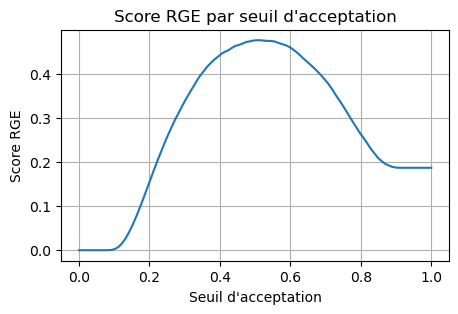

In [74]:
preds = apply_classifier(data_over, lgbm_clf)

print("--- LogisticRegression (oversampling) ---")
rge_train, rge_test = evaluate_preds(data_under, preds, display_curve = True)

## Importance des features

In [75]:
def plot_feature_importances(df, max_display, title) :
    
    df = df.sort_values("importance", ascending = False).reset_index()
    df["importance_normalized"] = df["importance"] / df["importance"].sum()

    plt.figure(figsize = (6, 4))
    ax = plt.subplot()
    
    ax.barh(list(reversed(list(df.index[:max_display]))), 
            df["importance_normalized"].head(max_display), 
            align = "center",
            edgecolor = "k")
    
    ax.set_yticks(list(reversed(list(df.index[:max_display]))))
    ax.set_yticklabels(df["feature"].head(max_display))
    ax.tick_params(axis = "y", labelsize = 8)
    
    plt.xlabel("Importance normalisée")
    plt.title(title, size = 14)
    plt.show()
    
    return df.drop(columns = ["index"])

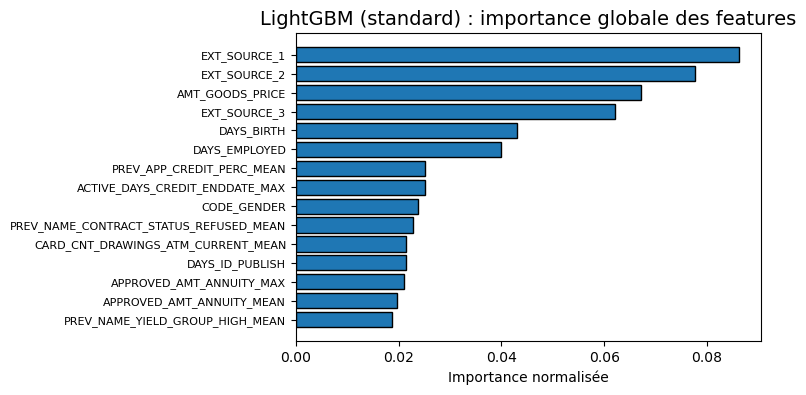

In [76]:
lgbm_feature_importances = pd.DataFrame({
        "feature" : list(processed_data["X_train"].columns),
        "importance" : lgbm_clf.feature_importances_
    })

title = "LightGBM (standard) : importance globale des features"
lgbm_feature_importances_sorted = plot_feature_importances(lgbm_feature_importances, 15, title)

In [77]:
def plot_shap_waterfall(classifier, X_test, row_index, title = None, max_display = 10) :

    explainer = shap.Explainer(classifier)
    shap_values = explainer(X_test)
    
    waterfall = shap.plots.waterfall(shap_values[row_index, :, 0], max_display = max_display, show = False)
    waterfall.set_size_inches(12, 8)
    
    if title is None :
        title = f"Importance des features pour la ligne {row_index}"
    
    plt.title(title, size = 20)
    plt.show()

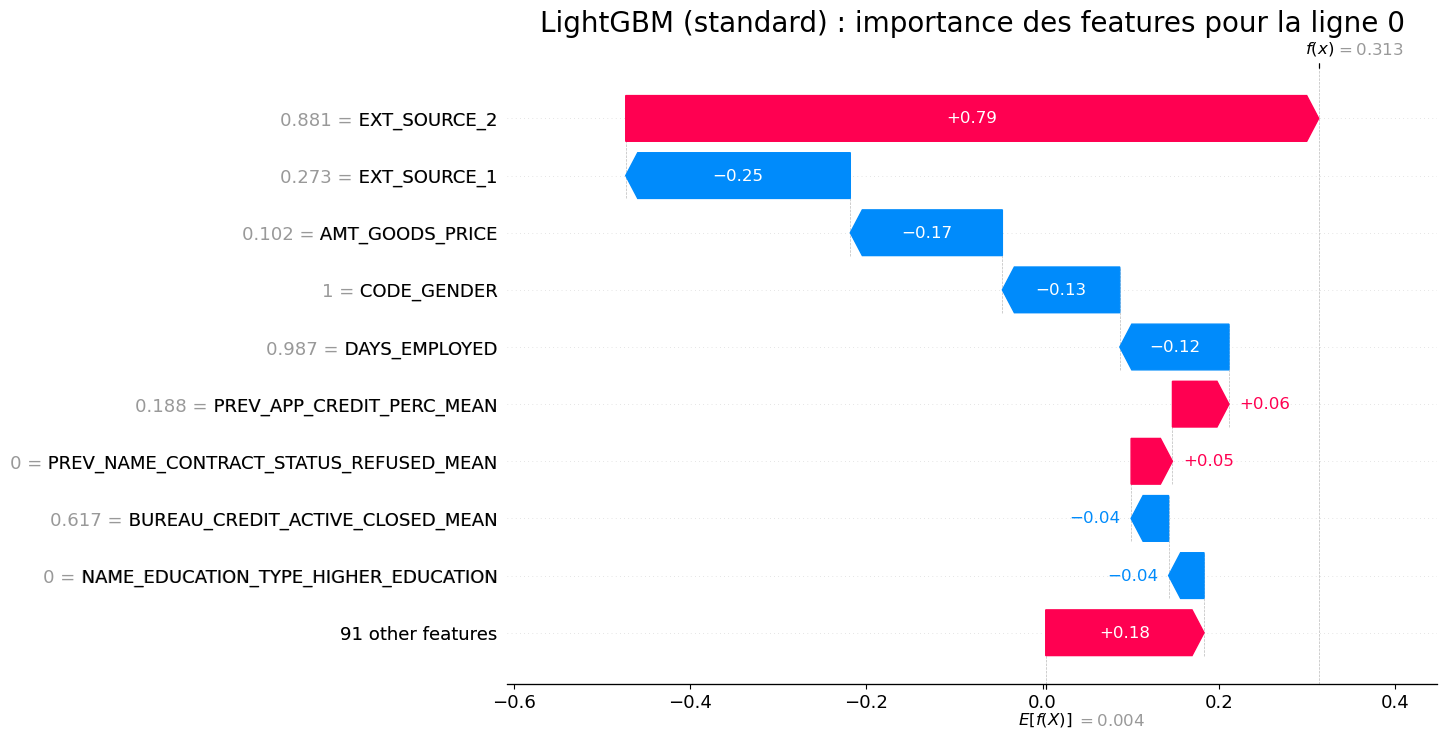

In [78]:
row_index = 0

title = f"LightGBM (standard) : importance des features pour la ligne {row_index}"
plot_shap_waterfall(lgbm_clf, processed_data["X_test"], row_index, title)

## Exportation du modèle

In [80]:
import pickle

with open("classifier.pkl", "wb") as file :
    pickle.dump(lgbm_clf, file)